In [1]:
from dask.distributed import Client, LocalCluster
import s3fs
import dask.dataframe as dd
import time
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import prophet

from dask_cloudprovider.azure import AzureVMCluster

Importing plotly failed. Interactive plots will not work.


In [2]:
# columns = ["when_captured",
#            "service_uploaded",
#             "loc_lat",
#             "loc_lon",
#             "opc_pm01_0",
#             "opc_pm02_5",
#             "opc_pm10_0",
#             "pms_pm01_0",
#             "pms_pm02_5",
#             "pms_pm10_0",
#             "pms2_pm01_0",
#             "pms2_pm02_5",
#             "pms2_pm10_0",
#             "lnd_712u",
#             "lnd_712c",
#             "lnd_7318u",
#             "lnd_7318c",
#             "lnd_7128ec",
#             "lnd_78017u",
#             "lnd_78017c",
#             "lnd_78017w",
#             "env_temp",
#             "env_humid",
#             "env_press"]

In [3]:
def create_azure_cluster_and_client():
    cluster = AzureVMCluster(resource_group="adzd_group_v3",
                             vnet="adzd_vnet_v3", 
                             location ="northeurope", 
                             security_group="adzd_security_v3",
                             n_workers=1)
    client = Client(cluster)
    return cluster, client

In [4]:
def create_local_cluster_and_client():
    cluster = LocalCluster()
    client = Client(cluster)
    return cluster,client

In [5]:
def scale_and_run_benchmark(cluster,df,benchmark_func,workers):
    cluster.scale(workers)
    start_time = time.time()
    result = benchmark_func(df)
    end_time = time.time()
    return result,end_time-start_time

In [6]:
def get_avg_radiation(payload):
    get_radiation_funcs = [get_lnd_712u, get_lnd_7318u, get_lnd_7318c, get_lnd_7128ec, get_lnd_78017u, get_lnd_78017c, get_lnd_78017w]
    measurements = [func(payload) for func in get_radiation_funcs]
    filtered = [m for m in measurements if m != None]
    msum = float(sum(filtered))
    mcount = len(filtered)
    return msum/mcount if mcount > 0 else None

In [7]:
get_when_captured = lambda payload: payload.get("when_captured",None)
get_lat = lambda payload: payload.get("loc_lat", None)
get_lon = lambda payload: payload.get("loc_lon", None)
# Jednostka dla poniższych: μSv/h
get_lnd_712u = lambda payload: payload.get("lnd_712c", None)
get_lnd_7318u = lambda payload: payload.get("lnd_7318u", None)
get_lnd_7318c = lambda payload: payload.get("lnd_7318c", None)
get_lnd_7128ec = lambda payload: payload.get("lnd_7128ec", None)
get_lnd_78017u = lambda payload: payload.get("lnd_78017u", None)
get_lnd_78017c = lambda payload: payload.get("lnd_78017c", None)
get_lnd_78017w = lambda payload: payload.get("lnd_78017w", None)

In [8]:
def read_data(date_string):
    df = dd.read_json(
            f's3://safecastdata-us-west-2/ingest/prd/s3raw/{date_string}', storage_options={'anon':True})
    return df

In [9]:
def read_data_for_multiple_days(year_and_month_string,first_day=1,last_day=30):
    paths = [
        f's3://safecastdata-us-west-2/ingest/prd/s3raw/{year_and_month_string}-{day:02}/*/*' for day in range(first_day,last_day+1)
    ]
    df = dd.read_json(
            paths, 
            storage_options={'anon': True}
        )
    return df

In [10]:
def prep_data(df):
    df_prep = df.copy()
    
    print("GET DATETIME")
    df_prep["datetime"] = df_prep["payload"].map(get_when_captured,meta=('datetime', str))
    
    print("GET LATITUDE AND LONGITUDE")
    df_prep["latitude"] = df_prep["payload"].map(get_lat,meta=('latitude', float))
    df_prep["longitude"] = df_prep["payload"].map(get_lon,meta=('longitude', float))
    
    print("GET RADIATION")
    df_prep["lnd_712u"] = df_prep["payload"].map(get_lnd_712u,meta=('712u', float))
    df_prep["lnd_7318u"] = df_prep["payload"].map(get_lnd_7318u,meta=('7318u', float))
    df_prep["lnd_7318c"] = df_prep["payload"].map(get_lnd_7318c,meta=('7318c', float))
    df_prep["lnd_7128ec"] = df_prep["payload"].map(get_lnd_7128ec,meta=('7128ec', float))
    df_prep["lnd_78017u"] = df_prep["payload"].map(get_lnd_78017u,meta=('78017u', float))
    df_prep["lnd_78017c"] = df_prep["payload"].map(get_lnd_78017c,meta=('78017c', float))
    df_prep["lnd_78017w"] = df_prep["payload"].map(get_lnd_78017w,meta=('78017w', float))
    df_prep["avg_radiation"] = df_prep["payload"].map(get_avg_radiation,meta=('avg_radiation', float))
    
    print("SELECT COLUMNS")
    df_prep = df_prep[["datetime","latitude","longitude","avg_radiation"]]
    
    print("REMOVE NULL VALUES")
    df_prep = df_prep.dropna(how='any')
    
    print("CONVERT STRING TO DATETIME")
    df_prep["datetime"] = dd.to_datetime(df_prep["datetime"])
    df_prep["date_with_hour"] = dd.to_datetime(df_prep["datetime"].apply(lambda dt: str(dt)[:10] + " " + str(dt)[11:13] + ":00", meta=('datetime',str)))
    
    print("REMOVE WRONG DATA BASED ON DATE")
    today = pd.datetime.today()
    df_prep = df_prep[df_prep['date_with_hour'].between('1980-01-01', today)]
    
    print("REMOVE OUTLIERS")
    # Keep only positive values
    df_prep = df_prep[df_prep["avg_radiation"] > 0]
    
    # Identifying outliers with the 1.5xIQR rule
    Q1 = df_prep['avg_radiation'].quantile(.25)
    Q3 = df_prep['avg_radiation'].quantile(.75)
    q1 = Q1 - 1.5 * (Q3 - Q1)
    Q4 = df_prep['avg_radiation'].quantile(0.995)
    df_prep = df_prep[df_prep['avg_radiation'].between(q1, Q4)]

    return df_prep

In [11]:
def show_sensors_locations_on_map(df):
    geometry = [Point(x,y) for x,y in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(geometry=geometry)   

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = gdf.plot(ax=world.plot(figsize=(15, 10)), marker='.', color='red', markersize=8)
    ax.set_title("Sensors' locations")
    plt.grid()
    plt.show()

In [12]:
def get_data_for_given_area(df,lon_min,lat_min,lon_max,lat_max):
    return df[(df.longitude > lon_min) & (df.longitude < lon_max) & (df.latitude > lat_min) & (df.latitude < lat_max)]

In [13]:
def filter_data_by_region(df,region):
    lon_min_jpn, lat_min_jpn, lon_max_jpn, lat_max_jpn = 128.03, 30.22, 148.65, 45.83 # Japan
    lon_min_fk, lat_min_fk, lon_max_fk, lat_max_fk = 140.0166, 37.0047, 141.2251, 38.195 # Fukushima
    lon_min_usa, lat_min_usa, lon_max_usa, lat_max_usa = -161.75583, 19.50139, -68.01197, 64.85694 # USA
    
    if region == "Japan":
        return get_data_for_given_area(df,lon_min_jpn,lat_min_jpn,lon_max_jpn,lat_max_jpn) 
    elif region == "Fukushima":
        return get_data_for_given_area(df,lon_min_fk,lat_min_fk,lon_max_fk,lat_max_fk)
    elif region == "USA":
        return get_data_for_given_area(df,lon_min_usa,lat_min_usa,lon_max_usa,lat_max_usa)
    else:
        return df

In [14]:
def get_avg_radiation_by_location(df):
    return df.groupby(by=["latitude","longitude"]).agg({'avg_radiation': ['mean', 'std']}).compute()

In [15]:
def get_avg_radiation_per_hour(df):
    return df.groupby(by=["date_with_hour"]).agg({'avg_radiation':'mean'}).compute()

In [16]:
def count_records(df):
    return df.count().compute()["avg_radiation"]

In [17]:
def count_unique_locations(df):
    return df.groupby(by=["latitude","longitude"]).count().count().compute()

In [18]:
def get_max_and_min_radiation(df):
    return {"min": df.avg_radiation.min().compute(), "max": df.avg_radiation.max().compute()}

In [19]:
def get_loc_with_max_radiation(df):
    max_val = df.avg_radiation.max().compute()
    pandas_df = df[df.avg_radiation == max_val].compute()
    lat = pandas_df.iloc[0]["latitude"]
    long = pandas_df.iloc[0]["longitude"]
    return {"latitude":lat,"longitude":long}

In [20]:
def run_benchmarks(cluster,df,cluster_type="local"):
    number_of_records = count_records(df)
    benchmarks = [count_records,count_unique_locations,get_avg_radiation_by_location,get_max_and_min_radiation,get_loc_with_max_radiation]
    workers_list = [1,2,3,4]
    
    results = []
    for benchmark in benchmarks:
        for workers in workers_list:
            print(f"RUNNING BENCHMARK {benchmark.__name__} USING {workers} WORKERS")
            _,duration = scale_and_run_benchmark(cluster,df,benchmark,workers)
            results.append({"records":number_of_records,"benchmark_func":benchmark.__name__,"workers":workers,"time":duration,"cluster_type":cluster_type})
            
    results_df = pd.DataFrame(results)
    
    time_one_instance = results_df.iloc[0].time
    results_df["speedup"] = time_one_instance/results_df["time"]
    results_df["efficiency"] = results_df["speedup"]/results_df["workers"]
            
    return results_df

In [21]:
def plot_efficiency(results,exclude_benchmarks=["count_records"]):
    benchmarks = [b for b in pd.unique(results["benchmark_func"]) if b not in exclude_benchmarks]
    colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:cyan"]
    assert(len(colors)>=len(benchmarks))
    used_colors = colors[:len(benchmarks)]
    
    for benchmark,color in zip(benchmarks,used_colors):
        filtered = results[results["benchmark_func"]==benchmark]
        plt.plot(filtered["workers"],filtered["efficiency"],c=color,label=benchmark,marker='o',linestyle='--')
    
    plt.xlabel("Number of worker instances")
    plt.ylabel("Efficiency")
    plt.ylim(ymin=0,ymax=1.1)
    plt.grid()
    plt.legend()
    plt.show()

In [22]:
def plot_acceleration(results,exclude_benchmarks=["count_records"]):
    benchmarks = [b for b in pd.unique(results["benchmark_func"]) if b not in exclude_benchmarks]
    colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:cyan"]
    assert(len(colors)>=len(benchmarks))
    used_colors = colors[:len(benchmarks)]
    
    for benchmark,color in zip(benchmarks,used_colors):
        filtered = results[results["benchmark_func"]==benchmark]
        plt.plot(filtered["workers"],filtered["speedup"],c=color,label=benchmark,marker='o',linestyle='--')
    
    plt.xlabel("Number of worker instances")
    plt.ylabel("Acceleration")
    plt.grid()
    plt.legend()
    plt.show()

In [23]:
def plot_time(results,exclude_benchmarks=["count_records"]):
    benchmarks = [b for b in pd.unique(results["benchmark_func"]) if b not in exclude_benchmarks]
    colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:cyan"]
    assert(len(colors)>=len(benchmarks))
    used_colors = colors[:len(benchmarks)]
    
    for benchmark,color in zip(benchmarks,used_colors):
        filtered = results[results["benchmark_func"]==benchmark]
        plt.plot(filtered["workers"],filtered["time"],c=color,label=benchmark,marker='o',linestyle='--')
    
    plt.xlabel("Number of worker instances")
    plt.ylabel("Time")
    plt.grid()
    plt.legend()
    plt.show()

In [24]:
# cluster,client = create_azure_cluster_and_client()

cluster,client = create_local_cluster_and_client()

In [25]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.89 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55304,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.89 GiB
Comm: tcp://127.0.0.1:55334,Total threads: 1
Dashboard: http://127.0.0.1:55335/status,Memory: 3.97 GiB
Nanny: tcp://127.0.0.1:55308,


In [26]:
pd.set_option('display.max_colwidth', None)

In [27]:
single_date_string = '2021-01-20/*/*'
df_single_date = read_data(single_date_string)
df_single_date.head()

,version,payload
0,1,"{'device_urn': 'pointcast:10042', 'device_class': 'pointcast', 'device_sn': 'POINTCAST #10042', 'device': 10042, 'when_captured': '2021-01-19T23:43:29Z', 'loc_lat': 37.7233303, 'loc_lon': 140.4767968, 'loc_alt': 145, 'loc_olc': '8R92PFFG+8PM', 'lnd_7318u': 47, 'service_uploaded': '2021-01-19T23:43:28Z', 'service_transport': 'pointcast:103.67.223.16', 'service_handler': 'i-051a2a353509414f0'}"
1,1,"{'device_urn': 'ngeigie:101', 'device_class': 'ngeigie', 'device_sn': 'NGEIGIE #101', 'device': 101, 'when_captured': '2021-01-19T23:43:32Z', 'loc_lat': 37.4932, 'loc_lon': 139.93305, 'loc_olc': '8Q9XFWVM+76M', 'lnd_7318u': 41, 'service_uploaded': '2021-01-19T23:43:32Z', 'service_transport': 'ngeigie:107.161.164.166', 'service_handler': 'i-0c65ac97805549e0d'}"
2,1,"{'device_urn': 'pointcast:10024', 'device_class': 'pointcast', 'device_sn': 'POINTCAST #10024', 'device': 10024, 'when_captured': '2021-01-19T23:44:26Z', 'loc_lat': 37.54562, 'loc_lon': 140.398995, 'loc_alt': 238, 'loc_olc': '8R92G9WX+6HX', 'lnd_7318u': 42, 'service_uploaded': '2021-01-19T23:44:26Z', 'service_transport': 'pointcast:121.95.34.165', 'service_handler': 'i-0c65ac97805549e0d'}"
3,1,"{'device_urn': 'pointcast:20105', 'device_class': 'pointcast', 'device_sn': 'POINTCAST #20105', 'device': 20105, 'when_captured': '2021-01-19T23:44:26Z', 'loc_lat': 38.3151, 'loc_lon': -123.0752, 'loc_olc': '84CR8W8F+2WV', 'lnd_78017w': 0, 'service_uploaded': '2021-01-19T23:44:26Z', 'service_transport': 'pointcast:12.235.42.3', 'service_handler': 'i-051cab8ec0fe30bcd'}"
4,1,"{'device_urn': 'pointcast:10024', 'device_class': 'pointcast', 'device_sn': 'POINTCAST #10024', 'device': 10024, 'when_captured': '2021-01-19T23:44:27Z', 'loc_lat': 37.54562, 'loc_lon': 140.398995, 'loc_alt': 238, 'loc_olc': '8R92G9WX+6HX', 'lnd_7128ec': 14, 'service_uploaded': '2021-01-19T23:44:27Z', 'service_transport': 'pointcast:121.95.34.165', 'service_handler': 'i-0c65ac97805549e0d'}"


In [28]:
df_single_date

,version,payload
npartitions=24,,
,int64,object
,...,...
...,...,...
,...,...
,...,...


In [29]:
df_sd_prep = prep_data(df_single_date)

GET DATETIME
GET LATITUDE AND LONGITUDE
GET RADIATION
SELECT COLUMNS
REMOVE NULL VALUES
CONVERT STRING TO DATETIME
REMOVE WRONG DATA BASED ON DATE


C:\Users\hplmi\.conda\envs\dask_venv_v2\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [30]:
df_sd_prep

,datetime,latitude,longitude,avg_radiation,date_with_hour
npartitions=24,,,,,
,datetime64[ns],float64,float64,float64,datetime64[ns]
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [31]:
df_sd_prep.head()

,datetime,latitude,longitude,avg_radiation,date_with_hour
0,2021-01-19 23:43:29+00:00,37.72333,140.476797,47.0,2021-01-19 23:00:00
1,2021-01-19 23:43:32+00:00,37.49320,139.933050,41.0,2021-01-19 23:00:00
2,2021-01-19 23:44:26+00:00,37.54562,140.398995,42.0,2021-01-19 23:00:00
3,2021-01-19 23:44:26+00:00,38.31510,-123.075200,0.0,2021-01-19 23:00:00
4,2021-01-19 23:44:27+00:00,37.54562,140.398995,14.0,2021-01-19 23:00:00


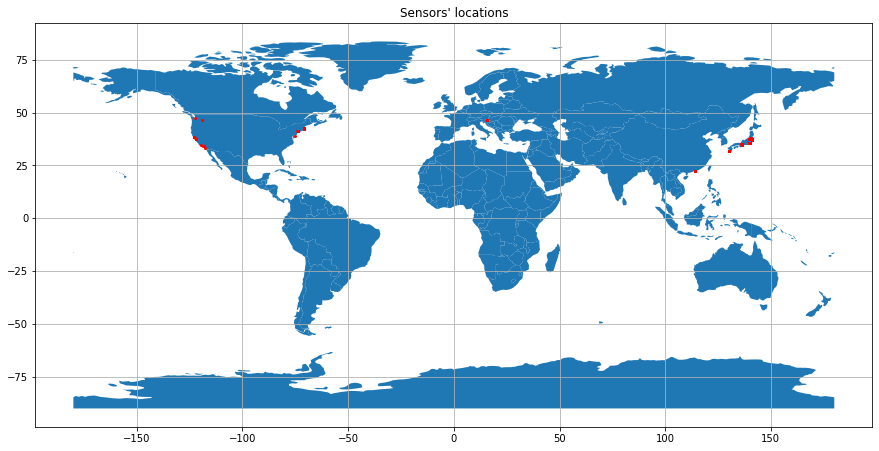

In [32]:
show_sensors_locations_on_map(df_sd_prep)

In [33]:
df_sd_jpn = filter_data_by_region(df_sd_prep,"Japan")
df_sd_fk = filter_data_by_region(df_sd_prep,"Fukushima")
df_sd_usa = filter_data_by_region(df_sd_prep,"USA")

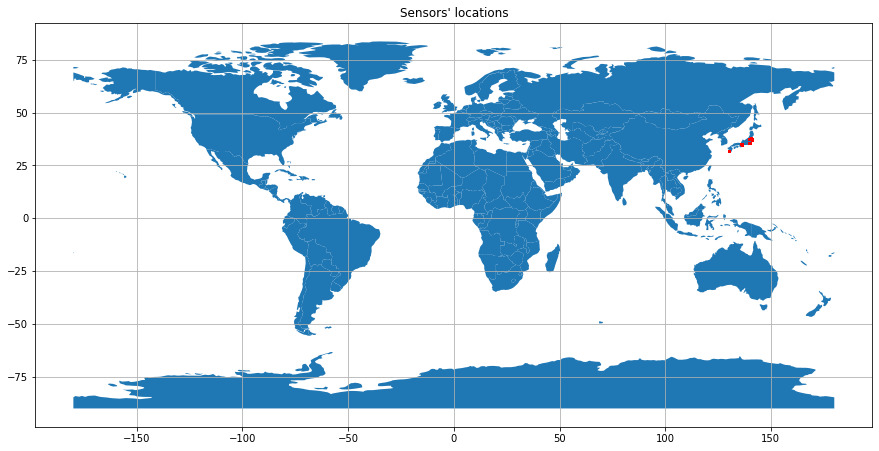

In [34]:
show_sensors_locations_on_map(df_sd_jpn)

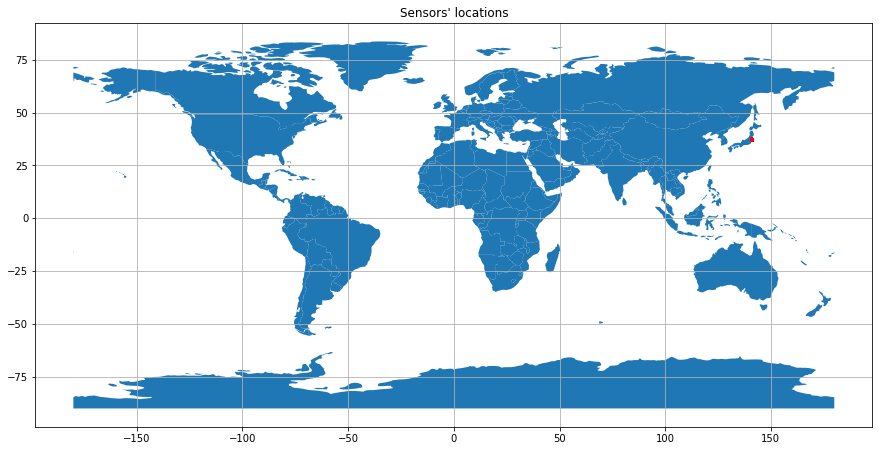

In [35]:
show_sensors_locations_on_map(df_sd_fk)

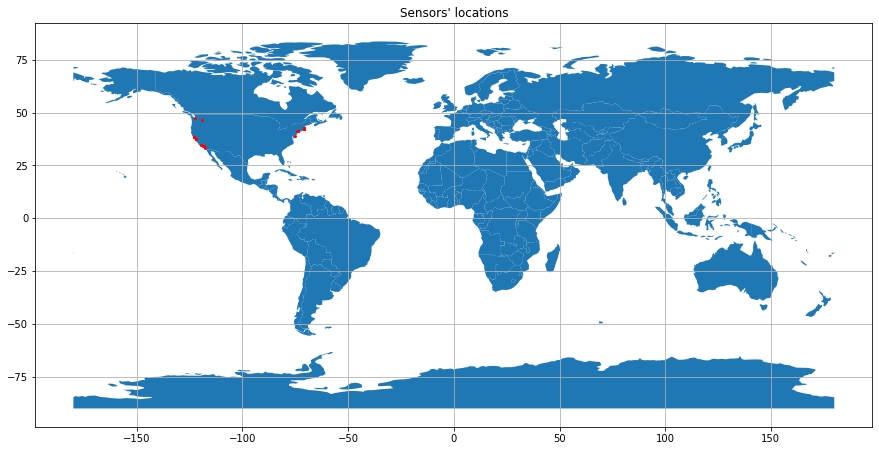

In [36]:
show_sensors_locations_on_map(df_sd_usa)

In [37]:
def is_2021(date):
    return date.year == 2021

In [38]:
df_sd_fk_grouped = get_avg_radiation_per_hour(df_sd_fk)

In [39]:
df_sd_fk_grouped.head()

,avg_radiation
date_with_hour,
2021-01-19 23:00:00,37.491228
2021-01-20 00:00:00,37.965000
2021-01-20 01:00:00,38.010204
2021-01-20 02:00:00,37.114583
2021-01-20 03:00:00,41.407500


In [40]:
fk_grouped = df_sd_fk_grouped.reset_index()
fk_grouped["year"] = fk_grouped["date_with_hour"].apply(is_2021)
fk_filtered = fk_grouped[fk_grouped["year"]]
fk_filtered

,date_with_hour,avg_radiation,year
0,2021-01-19 23:00:00,37.491228,True
1,2021-01-20 00:00:00,37.965000,True
2,2021-01-20 01:00:00,38.010204,True
3,2021-01-20 02:00:00,37.114583,True
4,2021-01-20 03:00:00,41.407500,True
5,2021-01-20 04:00:00,37.404040,True
6,2021-01-20 05:00:00,37.459184,True
7,2021-01-20 06:00:00,37.587629,True
8,2021-01-20 07:00:00,38.220588,True
9,2021-01-20 08:00:00,37.697436,True


In [41]:
df_sd_jpn_grouped = get_avg_radiation_per_hour(df_sd_jpn)

In [42]:
df_sd_jpn_grouped.head()

,avg_radiation
date_with_hour,
2021-01-19 23:00:00,33.910615
2021-01-20 00:00:00,33.614792
2021-01-20 01:00:00,32.867528
2021-01-20 02:00:00,33.194704
2021-01-20 03:00:00,33.893750


In [43]:
jpn_grouped = df_sd_jpn_grouped.reset_index()
jpn_grouped["year"] = jpn_grouped["date_with_hour"].apply(is_2021)
jpn_filtered = jpn_grouped[jpn_grouped["year"]]
jpn_filtered

,date_with_hour,avg_radiation,year
0,2021-01-19 23:00:00,33.910615,True
1,2021-01-20 00:00:00,33.614792,True
2,2021-01-20 01:00:00,32.867528,True
3,2021-01-20 02:00:00,33.194704,True
4,2021-01-20 03:00:00,33.893750,True
5,2021-01-20 04:00:00,32.149733,True
6,2021-01-20 05:00:00,31.696429,True
7,2021-01-20 06:00:00,30.135945,True
8,2021-01-20 07:00:00,30.685615,True
9,2021-01-20 08:00:00,93.548924,True


In [44]:
df_sd_usa_grouped = get_avg_radiation_per_hour(df_sd_usa)

In [45]:
df_sd_usa_grouped.head()

,avg_radiation
date_with_hour,
2021-01-19 23:00:00,20.750000
2021-01-20 00:00:00,21.386364
2021-01-20 01:00:00,20.730769
2021-01-20 02:00:00,21.086466
2021-01-20 03:00:00,20.662879


In [46]:
usa_grouped = df_sd_usa_grouped.reset_index()
usa_grouped["year"] = usa_grouped["date_with_hour"].apply(is_2021)
usa_filtered = usa_grouped[usa_grouped["year"]]
usa_filtered

,date_with_hour,avg_radiation,year
0,2021-01-19 23:00:00,20.750000,True
1,2021-01-20 00:00:00,21.386364,True
2,2021-01-20 01:00:00,20.730769,True
3,2021-01-20 02:00:00,21.086466,True
4,2021-01-20 03:00:00,20.662879,True
5,2021-01-20 04:00:00,20.803846,True
6,2021-01-20 05:00:00,21.279070,True
7,2021-01-20 06:00:00,21.477941,True
8,2021-01-20 07:00:00,21.079545,True
10,2021-01-20 08:00:00,21.477273,True


In [47]:
hours_fk = [str(d) for d in list(fk_filtered.index)]
hours_jpn = [str(d) for d in list(jpn_filtered.index)]
hours_usa = [str(d) for d in list(usa_filtered.index)]

values_fk = fk_filtered.avg_radiation
values_jpn = jpn_filtered.avg_radiation
values_usa = usa_filtered.avg_radiation

In [48]:
hours = [hours_fk,hours_jpn,hours_usa]
values = [values_fk,values_jpn,values_usa]
colors = ["tab:blue","tab:green","tab:red"]
regions = ["Fukushima","Japan","USA"]

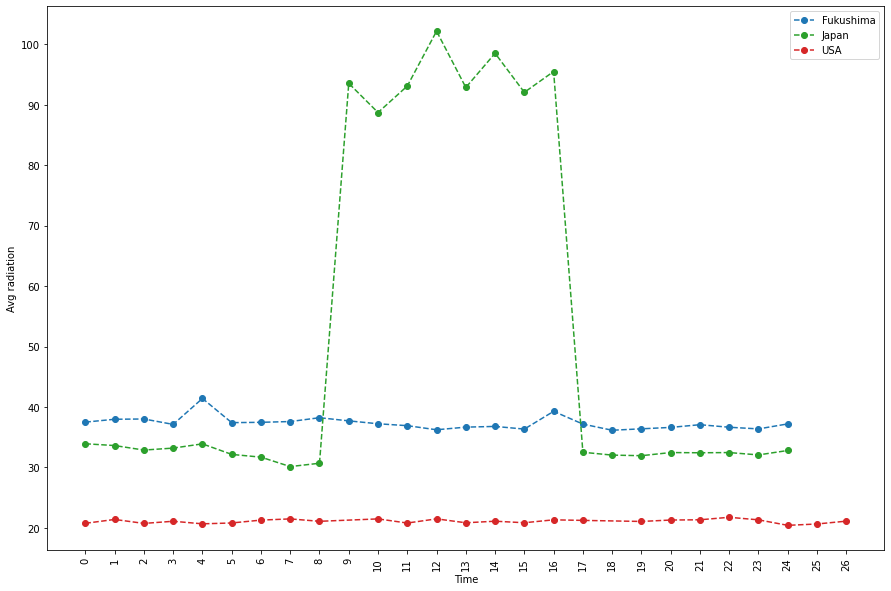

In [49]:
plt.figure(figsize=(15,10))

for color,(region,(h,v)) in zip(colors,zip(regions,zip(hours,values))):
    plt.plot(h,v,c=color,label=region,marker='o',linestyle='--')
    
plt.xlabel('Time')
plt.ylabel('Avg radiation')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [50]:
df_four_days = read_data_for_multiple_days("2021-01",first_day=20,last_day=23)

In [51]:
df_four_days.head()

,version,payload
0,1,"{'device_urn': 'pointcast:10042', 'device_class': 'pointcast', 'device_sn': 'POINTCAST #10042', 'device': 10042, 'when_captured': '2021-01-19T23:43:29Z', 'loc_lat': 37.7233303, 'loc_lon': 140.4767968, 'loc_alt': 145, 'loc_olc': '8R92PFFG+8PM', 'lnd_7318u': 47, 'service_uploaded': '2021-01-19T23:43:28Z', 'service_transport': 'pointcast:103.67.223.16', 'service_handler': 'i-051a2a353509414f0'}"
1,1,"{'device_urn': 'ngeigie:101', 'device_class': 'ngeigie', 'device_sn': 'NGEIGIE #101', 'device': 101, 'when_captured': '2021-01-19T23:43:32Z', 'loc_lat': 37.4932, 'loc_lon': 139.93305, 'loc_olc': '8Q9XFWVM+76M', 'lnd_7318u': 41, 'service_uploaded': '2021-01-19T23:43:32Z', 'service_transport': 'ngeigie:107.161.164.166', 'service_handler': 'i-0c65ac97805549e0d'}"
2,1,"{'device_urn': 'pointcast:10024', 'device_class': 'pointcast', 'device_sn': 'POINTCAST #10024', 'device': 10024, 'when_captured': '2021-01-19T23:44:26Z', 'loc_lat': 37.54562, 'loc_lon': 140.398995, 'loc_alt': 238, 'loc_olc': '8R92G9WX+6HX', 'lnd_7318u': 42, 'service_uploaded': '2021-01-19T23:44:26Z', 'service_transport': 'pointcast:121.95.34.165', 'service_handler': 'i-0c65ac97805549e0d'}"
3,1,"{'device_urn': 'pointcast:20105', 'device_class': 'pointcast', 'device_sn': 'POINTCAST #20105', 'device': 20105, 'when_captured': '2021-01-19T23:44:26Z', 'loc_lat': 38.3151, 'loc_lon': -123.0752, 'loc_olc': '84CR8W8F+2WV', 'lnd_78017w': 0, 'service_uploaded': '2021-01-19T23:44:26Z', 'service_transport': 'pointcast:12.235.42.3', 'service_handler': 'i-051cab8ec0fe30bcd'}"
4,1,"{'device_urn': 'pointcast:10024', 'device_class': 'pointcast', 'device_sn': 'POINTCAST #10024', 'device': 10024, 'when_captured': '2021-01-19T23:44:27Z', 'loc_lat': 37.54562, 'loc_lon': 140.398995, 'loc_alt': 238, 'loc_olc': '8R92G9WX+6HX', 'lnd_7128ec': 14, 'service_uploaded': '2021-01-19T23:44:27Z', 'service_transport': 'pointcast:121.95.34.165', 'service_handler': 'i-0c65ac97805549e0d'}"


In [52]:
df_fd_prep = prep_data(df_four_days)

GET DATETIME
GET LATITUDE AND LONGITUDE
GET RADIATION
SELECT COLUMNS
REMOVE NULL VALUES
CONVERT STRING TO DATETIME
REMOVE WRONG DATA BASED ON DATE


C:\Users\hplmi\.conda\envs\dask_venv_v2\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [53]:
df_fd_prep.head()

,datetime,latitude,longitude,avg_radiation,date_with_hour
0,2021-01-19 23:43:29+00:00,37.72333,140.476797,47.0,2021-01-19 23:00:00
1,2021-01-19 23:43:32+00:00,37.49320,139.933050,41.0,2021-01-19 23:00:00
2,2021-01-19 23:44:26+00:00,37.54562,140.398995,42.0,2021-01-19 23:00:00
3,2021-01-19 23:44:26+00:00,38.31510,-123.075200,0.0,2021-01-19 23:00:00
4,2021-01-19 23:44:27+00:00,37.54562,140.398995,14.0,2021-01-19 23:00:00


In [54]:
df_fd_fk_grouped = get_avg_radiation_per_hour(filter_data_by_region(df_fd_prep,"Fukushima")).reset_index()

In [55]:
df_fd_fk_grouped["is_2021"] = df_fd_fk_grouped["date_with_hour"].apply(is_2021)

In [56]:
forecast_df = df_fd_fk_grouped[df_fd_fk_grouped["is_2021"]][["date_with_hour","avg_radiation"]]

In [57]:
forecast_df.head()

,date_with_hour,avg_radiation
0,2021-01-19 23:00:00,37.491228
1,2021-01-20 00:00:00,37.965000
2,2021-01-20 01:00:00,38.010204
3,2021-01-20 02:00:00,37.114583
4,2021-01-20 03:00:00,41.407500


In [58]:
forecast_df.rename(columns={"date_with_hour":"ds","avg_radiation":"y"},inplace=True)

In [59]:
forecast_df.head()

,ds,y
0,2021-01-19 23:00:00,37.491228
1,2021-01-20 00:00:00,37.965000
2,2021-01-20 01:00:00,38.010204
3,2021-01-20 02:00:00,37.114583
4,2021-01-20 03:00:00,41.407500


In [60]:
len(forecast_df)

97

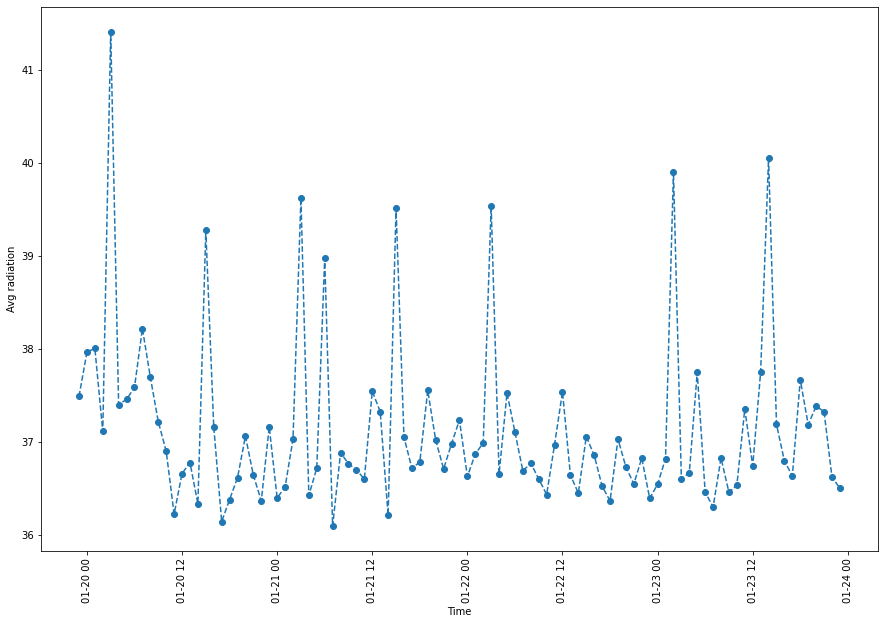

In [61]:
plt.figure(figsize=(15,10))

plt.plot(forecast_df["ds"],forecast_df["y"],marker='o',linestyle='--')
    
plt.xlabel('Time')
plt.ylabel('Avg radiation')
plt.xticks(rotation=90)
plt.show()

In [62]:
# based on: https://examples.dask.org/applications/forecasting-with-prophet.html

In [63]:
# ! pip3 install pystan==2.19.1.1

In [64]:
# ! pip3 install prophet

In [65]:
from prophet import Prophet

In [66]:
m = Prophet()
m.fit(forecast_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [67]:
future = m.make_future_dataframe(periods=100, freq='H')

In [68]:
fcst = m.predict(future)

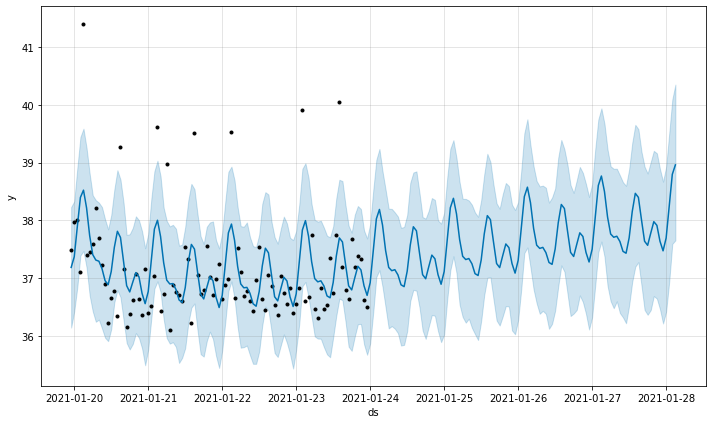

In [69]:
fig = m.plot(fcst)

In [70]:
# Z dokumentacji:
# Prophet includes a prophet.diagnostics.cross_validation function method, which uses simulated historical forecasts to provide some idea of a model’s quality.
# This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. 
# We can then compare the forecasted values to the actual values.
# Internally, cross_validation generates a list of cutoff values to try. 
# Prophet fits a model and computes some metrics for each of these. 
# By default each model is fit sequentially, 
# but the models can be trained in parallel using the parallel= keyword. 
# On a single machine parallel="processes" is a good choice. For large problems where you’d like to distribute the work on a cluster, 
# use parallel="dask" after you’ve connected to the cluster by creating a Client.
# For large problems where you’d like to distribute the work on a cluster, use parallel="dask" after you’ve connected to the cluster by creating a Client.

In [71]:
df_cv = prophet.diagnostics.cross_validation(
    m, horizon="10 hours",
    parallel="dask"
)

INFO:prophet:Making 12 forecasts with cutoffs between 2021-01-21 06:00:00 and 2021-01-23 13:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:55304' processes=4 threads=4, memory=15.89 GiB>


In [72]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-21 07:00:00,37.281609,36.194868,38.449817,36.097778,2021-01-21 06:00:00
1,2021-01-21 08:00:00,37.297185,36.231312,38.461964,36.886364,2021-01-21 06:00:00
2,2021-01-21 09:00:00,36.862692,35.693582,38.051445,36.768018,2021-01-21 06:00:00
3,2021-01-21 10:00:00,36.064050,34.995511,37.142739,36.701835,2021-01-21 06:00:00
4,2021-01-21 11:00:00,35.424668,34.322549,36.529516,36.603604,2021-01-21 06:00:00
...,...,...,...,...,...,...
115,2021-01-23 19:00:00,36.584502,35.475997,37.620642,37.188073,2021-01-23 13:00:00
116,2021-01-23 20:00:00,36.766588,35.822711,37.760928,37.386364,2021-01-23 13:00:00
117,2021-01-23 21:00:00,36.771510,35.775490,37.867713,37.327354,2021-01-23 13:00:00
118,2021-01-23 22:00:00,36.588848,35.567387,37.607754,36.624424,2021-01-23 13:00:00


In [148]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
import numpy as np

In [149]:
forecast_df

,ds,y
0,2021-01-19 23:00:00,37.491228
1,2021-01-20 00:00:00,37.965000
2,2021-01-20 01:00:00,38.010204
3,2021-01-20 02:00:00,37.114583
4,2021-01-20 03:00:00,41.407500
...,...,...
92,2021-01-23 19:00:00,37.188073
93,2021-01-23 20:00:00,37.386364
94,2021-01-23 21:00:00,37.327354
95,2021-01-23 22:00:00,36.624424


In [150]:
forecast_df_ts = forecast_df.rename(columns={'ds': 'Period'})
forecast_df_ts.set_index("Period", inplace=True)

In [151]:
forecast_series = forecast_df_ts['y']

In [153]:
forecast_series = forecast_series.asfreq(freq='H')

In [154]:
forecast_series

Period
2021-01-19 23:00:00    37.491228
2021-01-20 00:00:00    37.965000
2021-01-20 01:00:00    38.010204
2021-01-20 02:00:00    37.114583
2021-01-20 03:00:00    41.407500
                         ...    
2021-01-23 19:00:00    37.188073
2021-01-23 20:00:00    37.386364
2021-01-23 21:00:00    37.327354
2021-01-23 22:00:00    36.624424
2021-01-23 23:00:00    36.504854
Freq: H, Name: y, Length: 97, dtype: float64

In [155]:
y = forecast_series

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy = "last", sp = 12)

forecaster.fit(y, fh = fh)
y_pred = forecaster.predict()

C:\Users\hplmi\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:93: FutureWarning:

Timestamp.freq is deprecated and will be removed in a future version

C:\Users\hplmi\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:95: FutureWarning:

Timestamp.freq is deprecated and will be removed in a future version

C:\Users\hplmi\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:65: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\hplmi\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:66: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\hplmi\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:68: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\hplmi\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:71: FutureWarning:

Ti

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='y'>)

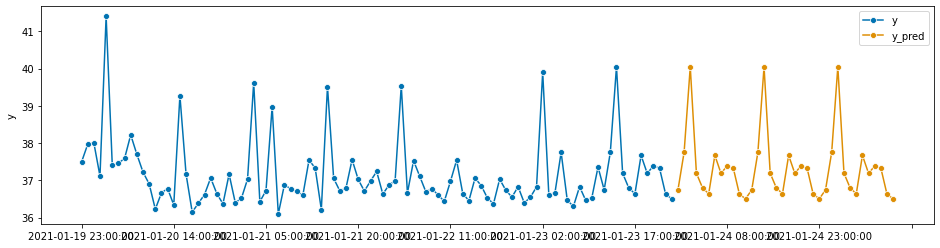

In [156]:
# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

In [73]:
sd_results = run_benchmarks(cluster,df_sd_prep)

RUNNING BENCHMARK count_records USING 1 WORKERS
RUNNING BENCHMARK count_records USING 2 WORKERS
RUNNING BENCHMARK count_records USING 3 WORKERS
RUNNING BENCHMARK count_records USING 4 WORKERS
RUNNING BENCHMARK count_unique_locations USING 1 WORKERS
RUNNING BENCHMARK count_unique_locations USING 2 WORKERS
RUNNING BENCHMARK count_unique_locations USING 3 WORKERS
RUNNING BENCHMARK count_unique_locations USING 4 WORKERS
RUNNING BENCHMARK get_avg_radiation_by_location USING 1 WORKERS
RUNNING BENCHMARK get_avg_radiation_by_location USING 2 WORKERS
RUNNING BENCHMARK get_avg_radiation_by_location USING 3 WORKERS
RUNNING BENCHMARK get_avg_radiation_by_location USING 4 WORKERS
RUNNING BENCHMARK get_max_and_min_radiation USING 1 WORKERS
RUNNING BENCHMARK get_max_and_min_radiation USING 2 WORKERS
RUNNING BENCHMARK get_max_and_min_radiation USING 3 WORKERS
RUNNING BENCHMARK get_max_and_min_radiation USING 4 WORKERS
RUNNING BENCHMARK get_loc_with_max_radiation USING 1 WORKERS
RUNNING BENCHMARK get_l

In [74]:
fd_results = run_benchmarks(cluster,df_fd_prep)

RUNNING BENCHMARK count_records USING 1 WORKERS
RUNNING BENCHMARK count_records USING 2 WORKERS
RUNNING BENCHMARK count_records USING 3 WORKERS
RUNNING BENCHMARK count_records USING 4 WORKERS
RUNNING BENCHMARK count_unique_locations USING 1 WORKERS
RUNNING BENCHMARK count_unique_locations USING 2 WORKERS
RUNNING BENCHMARK count_unique_locations USING 3 WORKERS
RUNNING BENCHMARK count_unique_locations USING 4 WORKERS
RUNNING BENCHMARK get_avg_radiation_by_location USING 1 WORKERS
RUNNING BENCHMARK get_avg_radiation_by_location USING 2 WORKERS
RUNNING BENCHMARK get_avg_radiation_by_location USING 3 WORKERS
RUNNING BENCHMARK get_avg_radiation_by_location USING 4 WORKERS
RUNNING BENCHMARK get_max_and_min_radiation USING 1 WORKERS
RUNNING BENCHMARK get_max_and_min_radiation USING 2 WORKERS
RUNNING BENCHMARK get_max_and_min_radiation USING 3 WORKERS
RUNNING BENCHMARK get_max_and_min_radiation USING 4 WORKERS
RUNNING BENCHMARK get_loc_with_max_radiation USING 1 WORKERS
RUNNING BENCHMARK get_l

In [75]:
sd_results

,records,benchmark_func,workers,time,cluster_type,speedup,efficiency
0,17180,count_records,1,19.173501,local,1.000000,1.000000
1,17180,count_records,2,12.740710,local,1.504901,0.752450
2,17180,count_records,3,10.836231,local,1.769388,0.589796
3,17180,count_records,4,8.449184,local,2.269272,0.567318
4,17180,count_unique_locations,1,19.857785,local,0.965541,0.965541
5,17180,count_unique_locations,2,12.214100,local,1.569784,0.784892
6,17180,count_unique_locations,3,10.637182,local,1.802498,0.600833
7,17180,count_unique_locations,4,9.410203,local,2.037523,0.509381
8,17180,get_avg_radiation_by_location,1,18.163405,local,1.055612,1.055612
9,17180,get_avg_radiation_by_location,2,11.697615,local,1.639095,0.819547


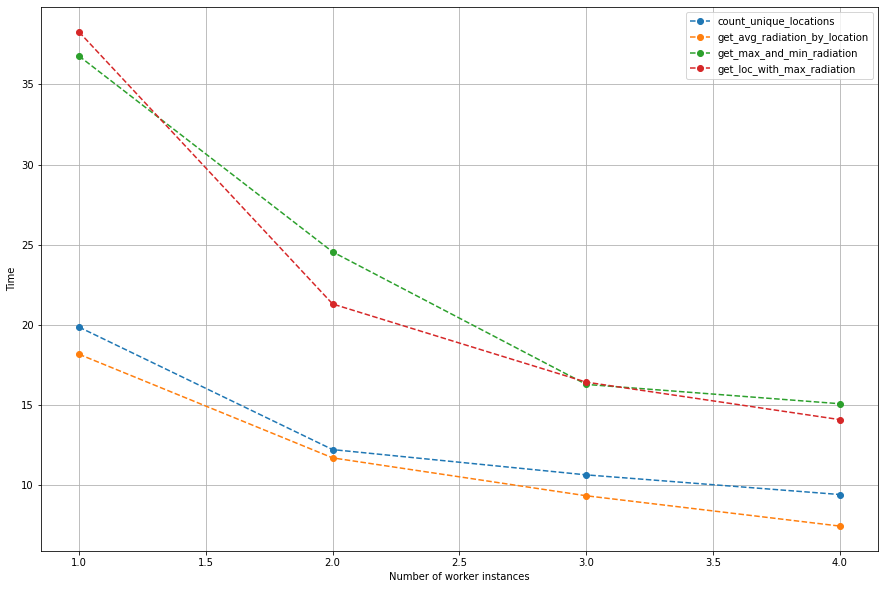

In [76]:
plt.figure(figsize=(15,10))
plot_time(sd_results)

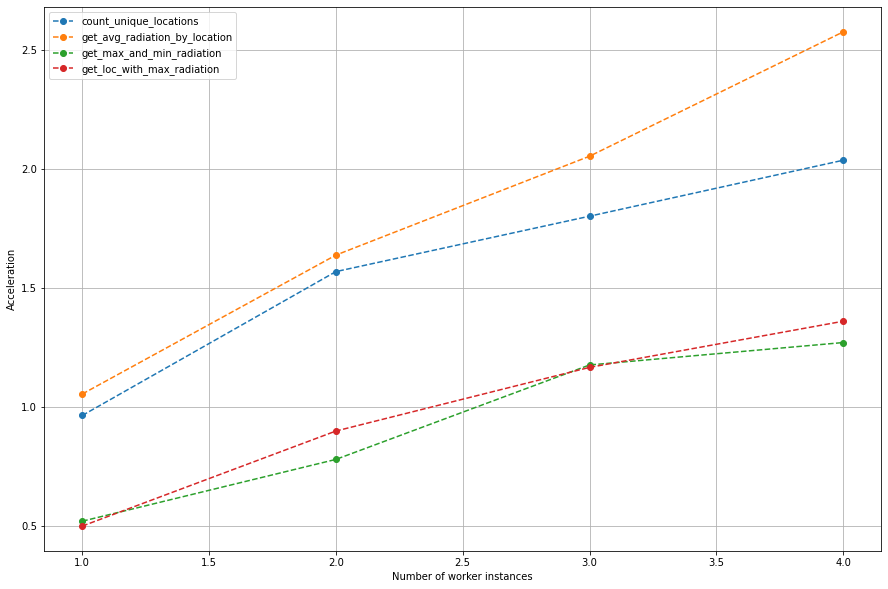

In [77]:
plt.figure(figsize=(15,10))
plot_acceleration(sd_results)

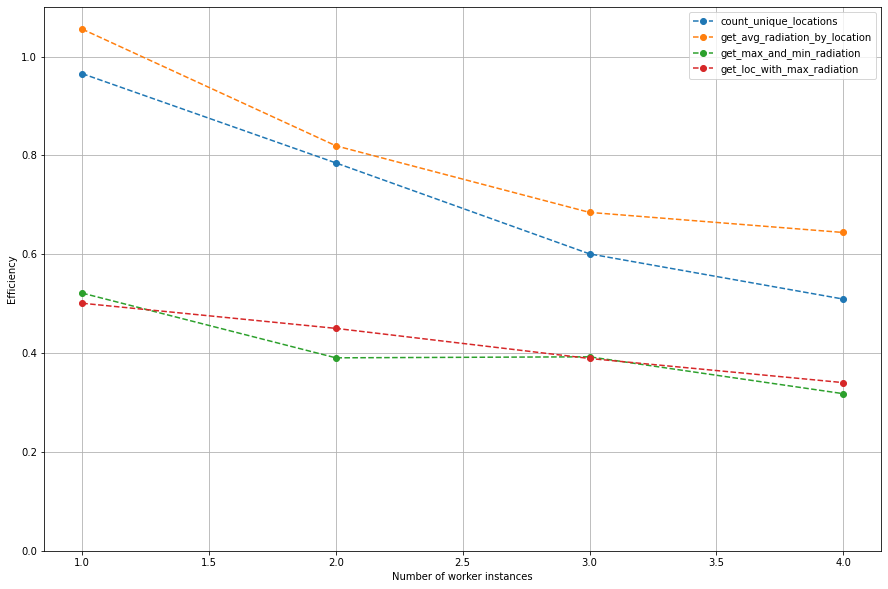

In [78]:
plt.figure(figsize=(15,10))
plot_efficiency(sd_results)

In [79]:
fd_results

,records,benchmark_func,workers,time,cluster_type,speedup,efficiency
0,68275,count_records,1,78.299118,local,1.000000,1.000000
1,68275,count_records,2,42.029524,local,1.862955,0.931478
2,68275,count_records,3,30.428301,local,2.573233,0.857744
3,68275,count_records,4,24.229749,local,3.231528,0.807882
4,68275,count_unique_locations,1,77.198713,local,1.014254,1.014254
5,68275,count_unique_locations,2,41.288469,local,1.896392,0.948196
6,68275,count_unique_locations,3,30.709567,local,2.549665,0.849888
7,68275,count_unique_locations,4,26.616927,local,2.941704,0.735426
8,68275,get_avg_radiation_by_location,1,86.283931,local,0.907459,0.907459
9,68275,get_avg_radiation_by_location,2,41.695418,local,1.877883,0.938942


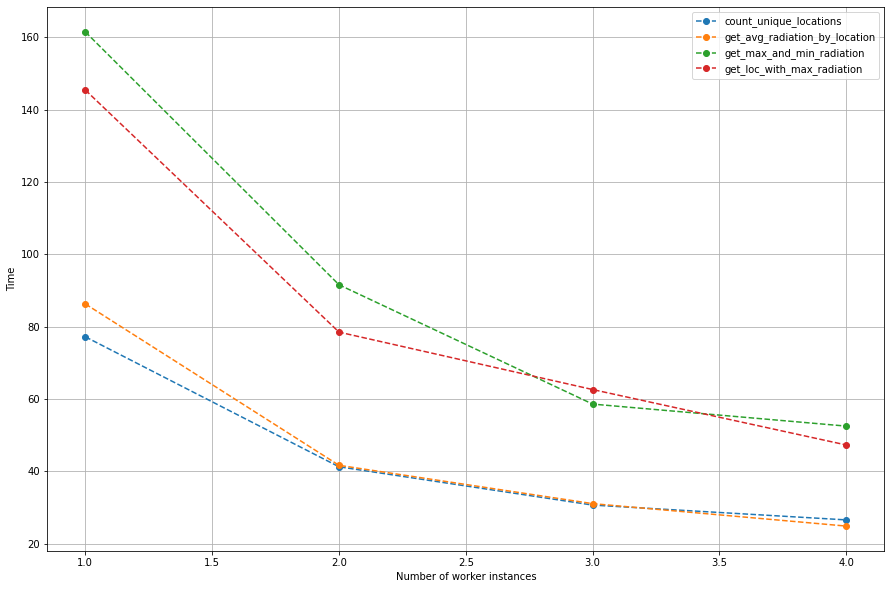

In [80]:
plt.figure(figsize=(15,10))
plot_time(fd_results)

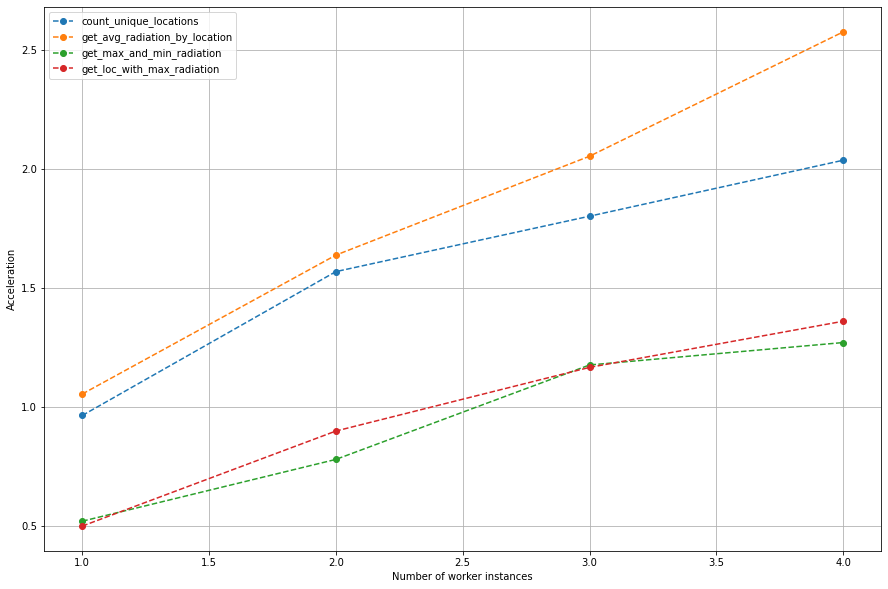

In [81]:
plt.figure(figsize=(15,10))
plot_acceleration(sd_results)

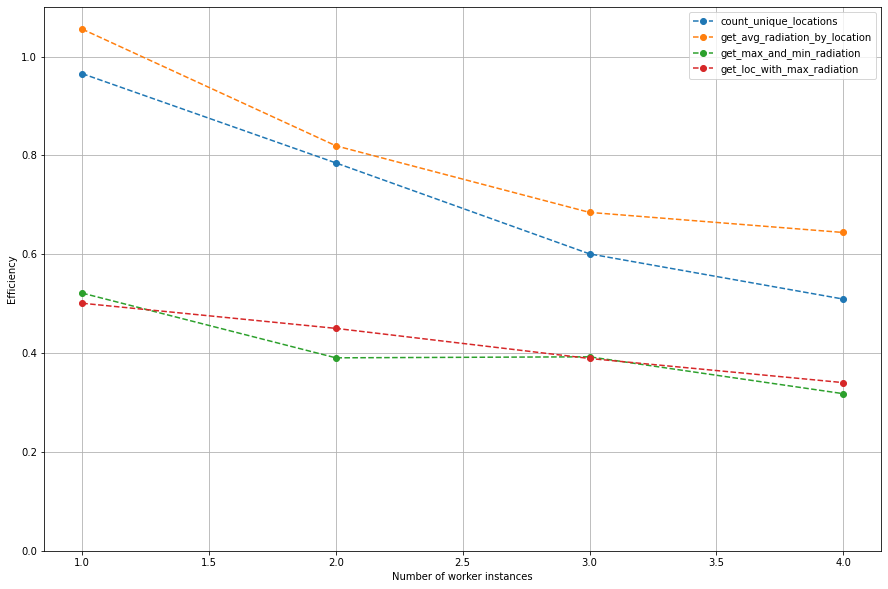

In [82]:
plt.figure(figsize=(15,10))
plot_efficiency(sd_results)